## Feature Selection

Why?
- Better performing model
- Easier-to-understand model
- Run faster

Set up model evaluation metric first.

1. Missing values
2. Amount of variation
3. Pairwise correlations
4. Correlation with the Target
5. Forward/backward selection (Sequential Feature Selector from mlxtend)
6. LASSO
7. Tree-based model to evaluate the imprtance of features

Scikit-learn codes

### 1. Removing features with low variance

As an example, suppose that we have a dataset with boolean features, and we want to remove all features that are either one or zero (on or off) in more than 80% of the samples.

In [53]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[0, 1],
       [1, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1]])

### 2. Univariate feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method.

In [60]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [56]:
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
X_new.shape

(150, 2)

### L1-based feature selection

Linear models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero. When the goal is to reduce the dimensionality of the data to use with another classifier, they can be used along with SelectFromModel to select the non-zero coefficients. In particular, sparse estimators useful for this purpose are the Lasso for regression, and of LogisticRegression and LinearSVC for classification.

In [61]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [63]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

(150, 3)

### 3. Tree-based feature selection

Tree-based estimators (see the sklearn.tree module and forest of trees in the sklearn.ensemble module) can be used to compute impurity-based feature importances, which in turn can be used to discard irrelevant features (when coupled with the SelectFromModel meta-transformer).

In [64]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
X, y = load_iris(return_X_y=True)
X.shape

(150, 4)

In [65]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  

array([0.10888493, 0.03869898, 0.40339993, 0.44901616])

In [66]:
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape               

(150, 2)

### 4. Correlation-based Feature Selection

Features which are highly correlated will be removed.

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading the dataset
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["MEDV"] = data.target

In [3]:
df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


In [5]:
X = df.drop("MEDV", axis=1)
y = df["MEDV"]

In [6]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [7]:
X_train.shape, X_test.shape

((354, 13), (152, 13))

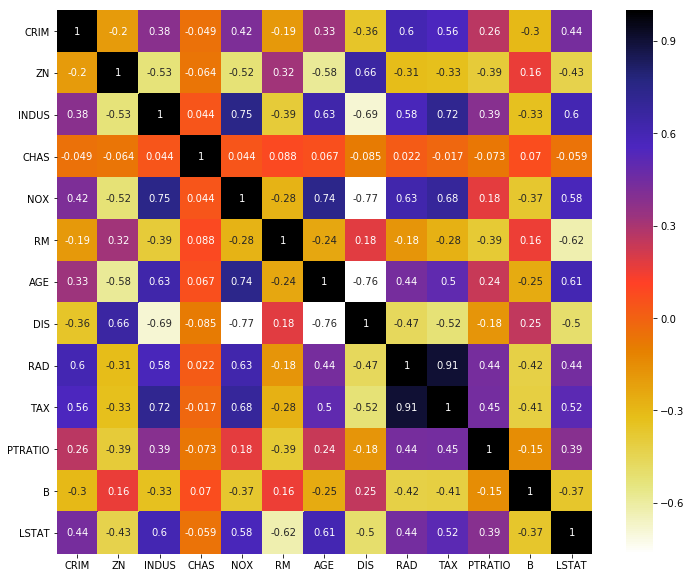

In [19]:
import seaborn as sns
# Using Pearson Correlation,range: -1 to +1
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [16]:
# with the following function we can select highly correlated features
# it will remove the first feture that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr 

# generally use 85% for threshold

In [22]:
corr_features = correlation(X_train, 0.7)
len(set(corr_features))

4

In [23]:
corr_features

{'AGE', 'DIS', 'NOX', 'TAX'}

In [24]:
X_train.drop(corr_features, axis=1)
X_test.drop(corr_features, axis=1)

CRIM    ZN  INDUS  CHAS     RM   RAD  PTRATIO       B  LSTAT
329   0.06724   0.0   3.24   0.0  6.333   4.0     16.9  375.21   7.34
371   9.23230   0.0  18.10   0.0  6.216  24.0     20.2  366.15   9.53
219   0.11425   0.0  13.89   1.0  6.373   5.0     16.4  393.74  10.50
403  24.80170   0.0  18.10   0.0  5.349  24.0     20.2  396.90  19.77
78    0.05646   0.0  12.83   0.0  6.232   5.0     18.7  386.40  12.34
15    0.62739   0.0   8.14   0.0  5.834   4.0     21.0  395.62   8.47
487   4.83567   0.0  18.10   0.0  5.905  24.0     20.2  388.22  11.45
340   0.06151   0.0   5.19   0.0  5.968   5.0     20.2  396.90   9.29
310   2.63548   0.0   9.90   0.0  4.973   4.0     18.4  350.45  12.64
102   0.22876   0.0   8.56   0.0  6.405   5.0     20.9   70.80  10.63
418  73.53410   0.0  18.10   0.0  5.957  24.0     20.2   16.45  20.62
411  14.05070   0.0  18.10   0.0  6.657  24.0     20.2   35.05  21.22
446   6.28807   0.0  18.10   0.0  6.341  24.0     20.2  318.01  17.79
386  24.39380   0.0  18.10   0.0  4.652  24.0     20.2  396.90  28.28
162   1.83377   0.0  19.58   1.0  7.802   5.0     14.7  389.61   1.92
299   0.05561  70.0   2.24   0.0  7.041   5.0     14.8  371.58   4.74
480   5.82401   0.0  18.10   0.0  6.242  24.0     20.2  396.90  10.74
196   0.04011  80.0   1.52   0.0  7.287   2.0     12.6  396.90   4.08
175   0.06664   0.0   4.05   0.0  6.546   5.0     16.6  390.96   5.33
37    0.08014   0.0   5.96   0.0  5.850   5.0     19.2  396.90   8.77
320   0.16760   0.0   7.38   0.0  6.426   5.0     19.6  396.90   7.20
171   2.31390   0.0  19.58   0.0  5.880   5.0     14.7  348.13  12.03
107   0.13117   0.0   8.56   0.0  6.127   5.0     20.9  387.69  14.09
278   0.07978  40.0   6.41   0.0  6.482   4.0     17.6  396.90   7.19
45    0.17142   0.0   6.91   0.0  5.682   3.0     17.9  396.90  10.21
367  13.52220   0.0  18.10   0.0  3.863  24.0     20.2  131.42  13.33
21    0.85204   0.0   8.14   0.0  5.965   4.0     21.0  392.53  13.83
153   2.14918   0.0  19.58   0.0  5.709   5.0     14.7  261.95  15.79
97    0.12083   0.0   2.89   0.0  8.069   2.0     18.0  396.90   4.21
113   0.22212   0.0  10.01   0.0  6.092   6.0     17.8  396.90  17.09
..        ...   ...    ...   ...    ...   ...      ...     ...    ...
49    0.21977   0.0   6.91   0.0  5.602   3.0     17.9  396.90  16.20
498   0.23912   0.0   9.69   0.0  6.019   6.0     19.2  396.90  12.92
309   0.34940   0.0   9.90   0.0  5.972   4.0     18.4  396.24   9.97
124   0.09849   0.0  25.65   0.0  5.879   2.0     19.1  379.38  17.58
306   0.07503  33.0   2.18   0.0  7.420   7.0     18.4  396.90   6.47
245   0.19133  22.0   5.86   0.0  5.605   7.0     19.1  389.13  18.46
59    0.10328  25.0   5.13   0.0  5.927   8.0     19.7  396.90   9.22
276   0.10469  40.0   6.41   1.0  7.267   4.0     17.6  389.25   6.05
395   8.71675   0.0  18.10   0.0  6.471  24.0     20.2  391.98  17.12
416  10.83420   0.0  18.10   0.0  6.782  24.0     20.2   21.57  25.79
491   0.10574   0.0  27.74   0.0  5.983   4.0     20.1  390.11  18.07
170   1.20742   0.0  19.58   0.0  5.875   5.0     14.7  292.29  14.43
419  11.81230   0.0  18.10   0.0  6.824  24.0     20.2   48.45  22.74
55    0.01311  90.0   1.22   0.0  7.249   5.0     17.9  395.93   4.81
235   0.33045   0.0   6.20   0.0  6.086   8.0     17.4  376.75  10.88
142   3.32105   0.0  19.58   1.0  5.403   5.0     14.7  396.90  26.82
249   0.19073  22.0   5.86   0.0  6.718   7.0     19.1  393.74   6.56
415  18.08460   0.0  18.10   0.0  6.434  24.0     20.2   27.25  29.05
378  23.64820   0.0  18.10   0.0  6.380  24.0     20.2  396.90  23.69
494   0.27957   0.0   9.69   0.0  5.926   6.0     19.2  396.90  13.59
179   0.05780   0.0   2.46   0.0  6.980   3.0     17.8  396.90   5.04
52    0.05360  21.0   5.64   0.0  6.511   4.0     16.8  396.90   5.28
74    0.07896   0.0  12.83   0.0  6.273   5.0     18.7  394.92   6.78
26    0.67191   0.0   8.14   0.0  5.813   4.0     21.0  376.88  14.81
200   0.01778  95.0   1.47   0.0  7.135   3.0     17.0  384.30   4.45
4     0.06905   0.0

### 5. Maximum Relevance and Minimum Redundancy

When using MRMR, you are basically required to make only one choice: deciding the number of features that you want to keep.

In real applications, **one can choose K based on domain knowledge or other constraints, such as model capacity, machine memory or time available.**

MRMR works iteratively. At each iteration, it identifies the best feature (according to a rule) and adds it to the basket of selected features. Once a feature goes into the bucket, it cannot ever come out.

"Maximum Relevance - Minimum Redundancy" is so called because — at each iteration — we want to select the feature that has **maximum relevance with respect to the target variable** and **minimum redundancy with respect to the features** that have been selected at previous iterations.

<img src=https://miro.medium.com/max/1400/1*GVhKoNKYdtGHB4ryQIA56A.png />

The **relevance** of a feature f at the i-th iteration (numerator) is computed as the F-statistic between the feature and the target variable.

The **redundancy** (denominator) is computed as the average (Pearson) correlation between the feature and all the features that have been selected at previous iterations.

<img src=https://miro.medium.com/max/1011/1*cAiP8k5_tP-IDMOxsKUh6g.png />

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
X_train.shape

(354, 13)

In [51]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_regression

X = X_train
y = y_train
K = 3

# inputs:
#    X: pandas.DataFrame, features
#    y: pandas.Series, target variable
#    K: number of features to select

# compute F-statistics and correlations
F = pd.Series(f_regression(X, y)[0], index = X.columns)
corr = X.corr().abs().clip(.00001) # minimum value of correlation set to .00001 (to avoid division by zero)

# initialize list of selected features and list of excluded features
selected = []
not_selected = list(X.columns)

In [52]:
# repeat K times
for i in range(K):
  
    # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
    if i > 0:
        last_selected = selected[-1]
        corr.loc[not_selected, last_selected] = X[not_selected].corrwith(X[last_selected]).abs().clip(.00001)
        
    # compute FCQ score for all the (currently) excluded features (this is Formula 2)
    score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)
    
    # find best feature, add it to selected and remove it from not_selected
    best = score.idxmax()
    selected.append(best)
    not_selected.remove(best)

print(selected, not_selected)


['LSTAT', 'RM', 'PTRATIO'] ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'AGE', 'DIS', 'RAD', 'TAX', 'B']
